Давайте познакомимся с одним из способов выделения трендовой и сезонной компонент ряда и визуального анализа шума.

In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
# from matplotlib import pyplot
import matplotlib.pyplot as plt
DIR="..\\..\\chunk\\15\\"


In [ ]:

#грузить этот сет не надо, он облегчен и надо грузить только выборку для магазина 25 ниже
df=pd.read_csv(f'{DIR}train.csv',sep=',',decimal='.',parse_dates=['date'])
df25=df[df.store_nbr==25]
df25.to_csv(f'{DIR}train25.csv',index=False)
df25.info()

In [16]:
df25=pd.read_csv(f'{DIR}train25.csv')
df25

c:\Users\User\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN
...,...,...,...,...,...,...
2057015,125440182,2017-08-15,25,2111870,11.0,False
2057016,125440183,2017-08-15,25,2113343,2.0,False
2057017,125440184,2017-08-15,25,2113914,1.0,False
2057018,125440185,2017-08-15,25,2116416,1.0,False


In [17]:
gdf25=df25[['date','unit_sales']].groupby(['date']).sum()
gdf25.head()

,unit_sales
date,
2013-01-01,2511.619
2013-01-02,5316.224
2013-01-03,4442.913
2013-01-04,4844.354
2013-01-05,5817.526


In [ ]:
# df_ = df[df.store_nbr==25].groupby("date")['unit_sales'].sum().reset_index()
# df_.head()

In [211]:
gdf25.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', name='date', length=1618, freq=None)

In [212]:
#приведение индекса к типу дат
gdf25 = gdf25.set_index(pd.DatetimeIndex(gdf25.index))
gdf25

,unit_sales,cdate,gap
date,,,
2013-01-01,2511.619,2013-01-01,NaN
2013-01-02,5316.224,2013-01-02,1.0
2013-01-03,4442.913,2013-01-03,1.0
2013-01-04,4844.354,2013-01-04,1.0
2013-01-05,5817.526,2013-01-05,1.0
...,...,...,...
2017-08-11,22800.841,2017-08-11,1.0
2017-08-12,15090.753,2017-08-12,1.0
2017-08-13,8570.598,2017-08-13,1.0


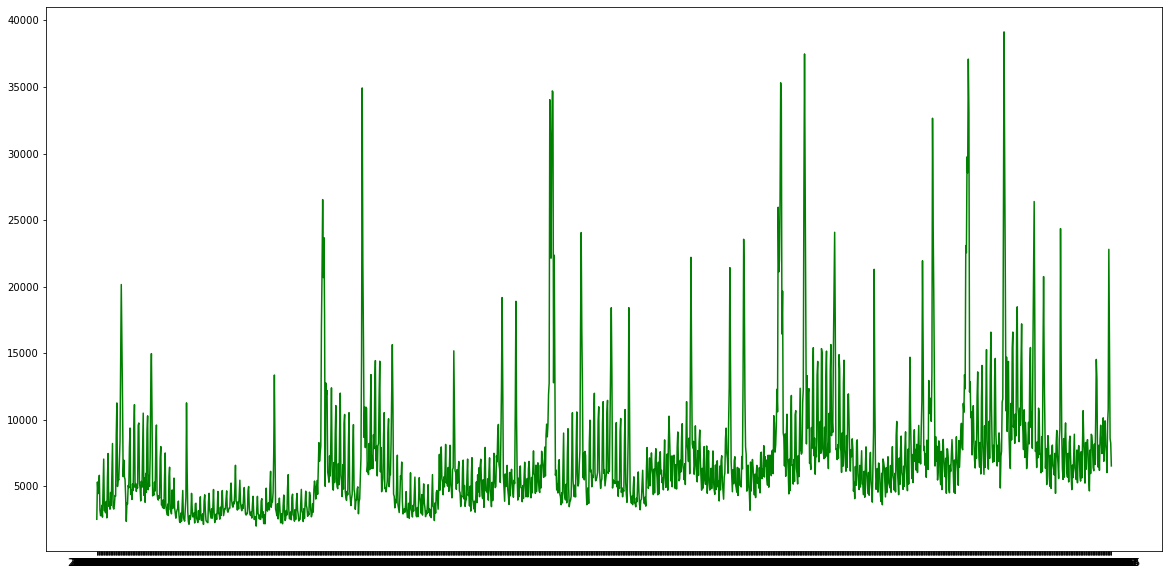

In [22]:
plt.rcParams["figure.figsize"]=(20,10)
plt.plot(gdf25, "g", label="date")

In [30]:
gdf25['cdate']=gdf25.index #дублировать даты в столбец
gdf25.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1618 entries, 2013-01-01 to 2017-08-15
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   unit_sales  1618 non-null   float64       
 1   cdate       1618 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 37.9 KB


In [31]:
#добавить колонку с промежутком от предыдущей даты то текущей
#т.к. есть пропуски в датах
gdf25['gap']=gdf25['cdate'] - gdf25['cdate'].shift(1)
gdf25['gap']=gdf25['gap'].dt.days #избавиться от timedelta
#взять обычный промежуток(большинство)
delta=gdf25.iloc[1]['gap']
#найти даты,строки которых имеют предыдушие строки, отличающиеся не на delta 
# (первую строку не учитывать,т.к. для нее не было предыдущей строки)
dates=gdf25[gdf25.gap!=delta].index[1:]
dates #имеем даты, перед которыми дырки, отличающиеся от большинства

DatetimeIndex(['2013-12-26', '2014-12-26', '2015-12-26', '2016-10-27',
               '2016-12-26'],
              dtype='datetime64[ns]', name='date', freq=None)

In [32]:
#индексы рядов, перед которыми увеличенные промежутки
for dt in dates:
    sgaps=gdf25.index.get_loc(gdf25.loc[dt].name)
    print(sgaps,gdf25.iloc[sgaps]['cdate'])
   

358 2013-12-26 00:00:00
722 2014-12-26 00:00:00
1086 2015-12-26 00:00:00
1326 2016-10-27 00:00:00
1385 2016-12-26 00:00:00


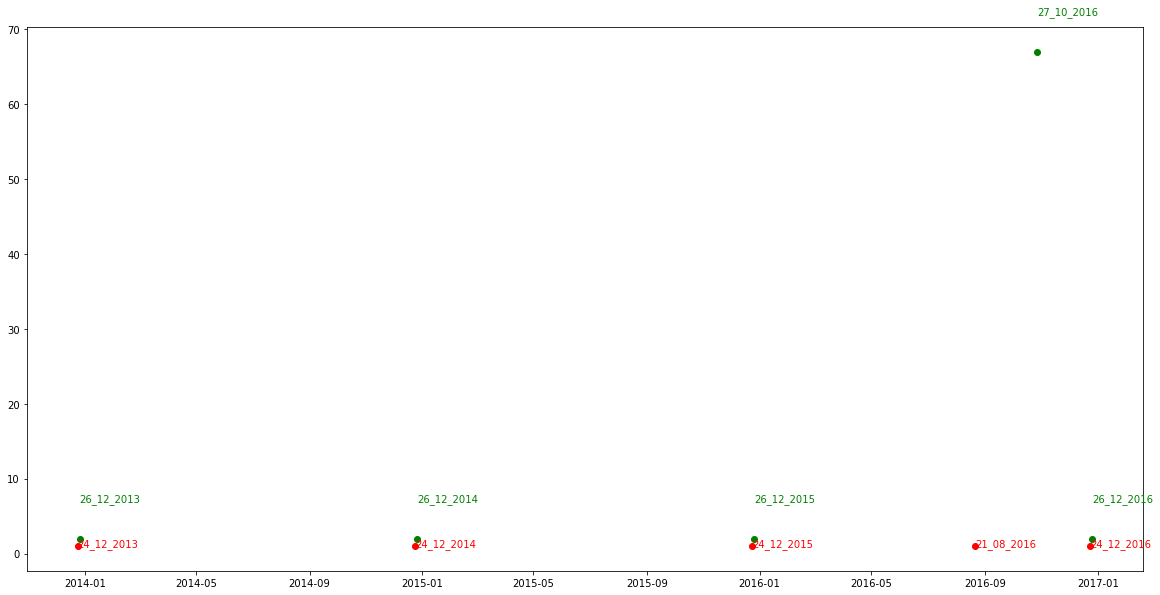

In [33]:
#на графике показаны даты, между которыми есть увеличенные промежутки, не равные как везде одному дню
import matplotlib.transforms as mtransforms

#специальная выборка рядов, где перед ними отсутствуют ряды с непрерывным индексом
#(а с прерывным индексом не работает seasonal_decompose, если не указать период)
gdf25cut=gdf25[gdf25.gap!=delta][1:]
gdf25cut['prev']=gdf25cut['cdate'].apply(lambda x: gdf25['cdate'].iloc[gdf25.index.get_loc(gdf25.loc[x].name)-1])
plt.plot(gdf25cut['prev'],np.ones(len(gdf25cut.index))*delta, "ro", label="prevdate")
plt.plot(gdf25cut['cdate'],gdf25cut['gap'], "go", label="date")
for x,y,x_1 in zip(gdf25cut['cdate'],gdf25cut['gap'],gdf25cut['prev']):
    plt.text(x,y+5, f"{x.strftime('%d_%m_%Y')}",color='green') 
    plt.text(x_1,delta, f"{x_1.strftime('%d_%m_%Y')}",color='red') 

In [106]:
gdf25cut

,unit_sales,gap,gap_,cdate,prev
date,,,,,
2013-12-26,16904.571,2.0,2.0,2013-12-26,2013-12-24
2014-12-26,34044.995,2.0,2.0,2014-12-26,2013-12-24
2015-12-26,25963.391,2.0,2.0,2015-12-26,2013-12-24
2016-10-27,12941.326,67.0,67.0,2016-10-27,2013-12-24
2016-12-26,23082.846,2.0,2.0,2016-12-26,2013-12-24


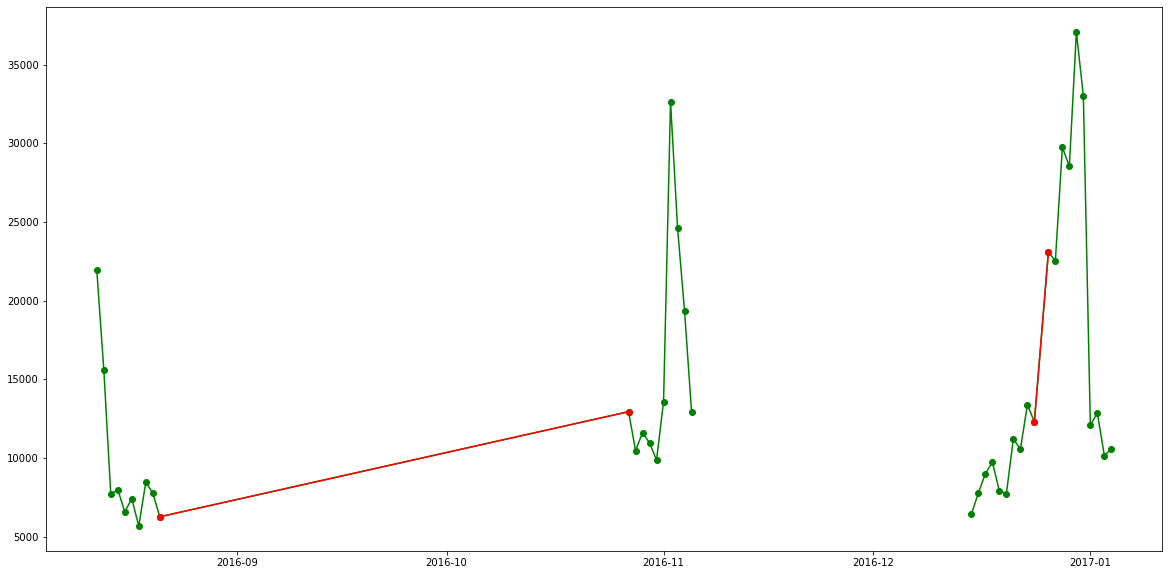

In [34]:
#красным показаны участки с пропусками данных(2 последних)
#seasonal_decompose не работает из-за пропусков
def plgdf(gdf25,back=10):
    for dt in dates[3:]:
        sgaps=gdf25.index.get_loc(gdf25.loc[dt].name)
        gdf25_=gdf25.iloc[(sgaps-back):sgaps+10]
        gdf25__=gdf25.iloc[(sgaps-1):sgaps+1]
        plt.plot(gdf25_.index,gdf25_['unit_sales'], "go-")
        plt.plot(gdf25__.index,gdf25__['unit_sales'], "ro-")

plgdf(gdf25)

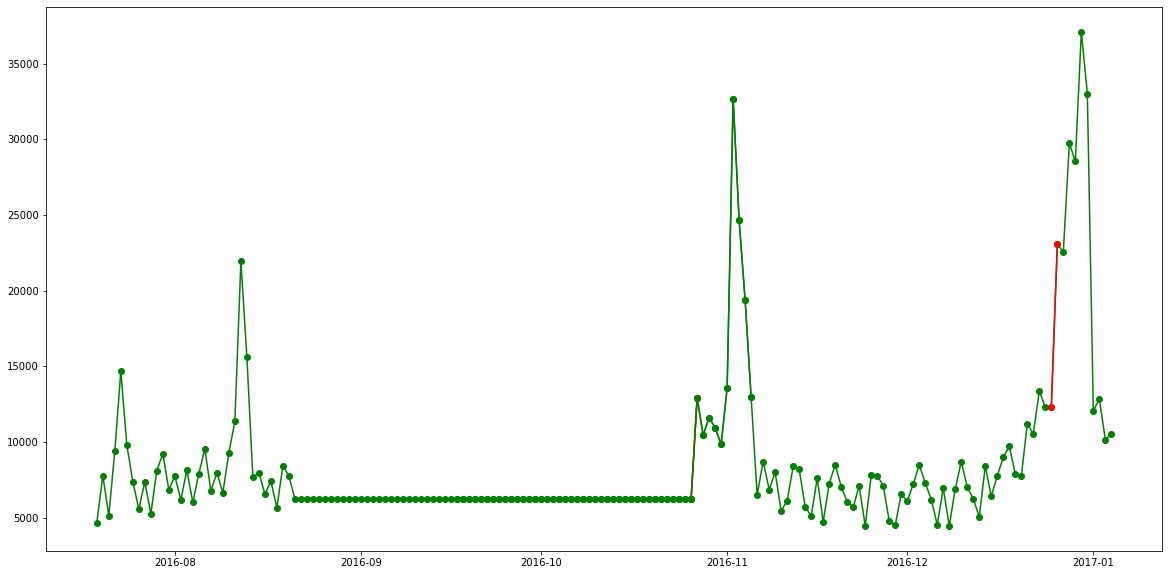

In [35]:
#заполнить пропуски, чтобы ежедневный индекс шел непрерывно
_gdf25=gdf25.asfreq('D',method='ffill')
plgdf(_gdf25,100)

In [37]:
_gdf25.drop(['gap','cdate'],axis=1,inplace=True)
_gdf25

,unit_sales
date,
2013-01-01,2511.619
2013-01-02,5316.224
2013-01-03,4442.913
2013-01-04,4844.354
2013-01-05,5817.526
...,...
2017-08-11,22800.841
2017-08-12,15090.753
2017-08-13,8570.598


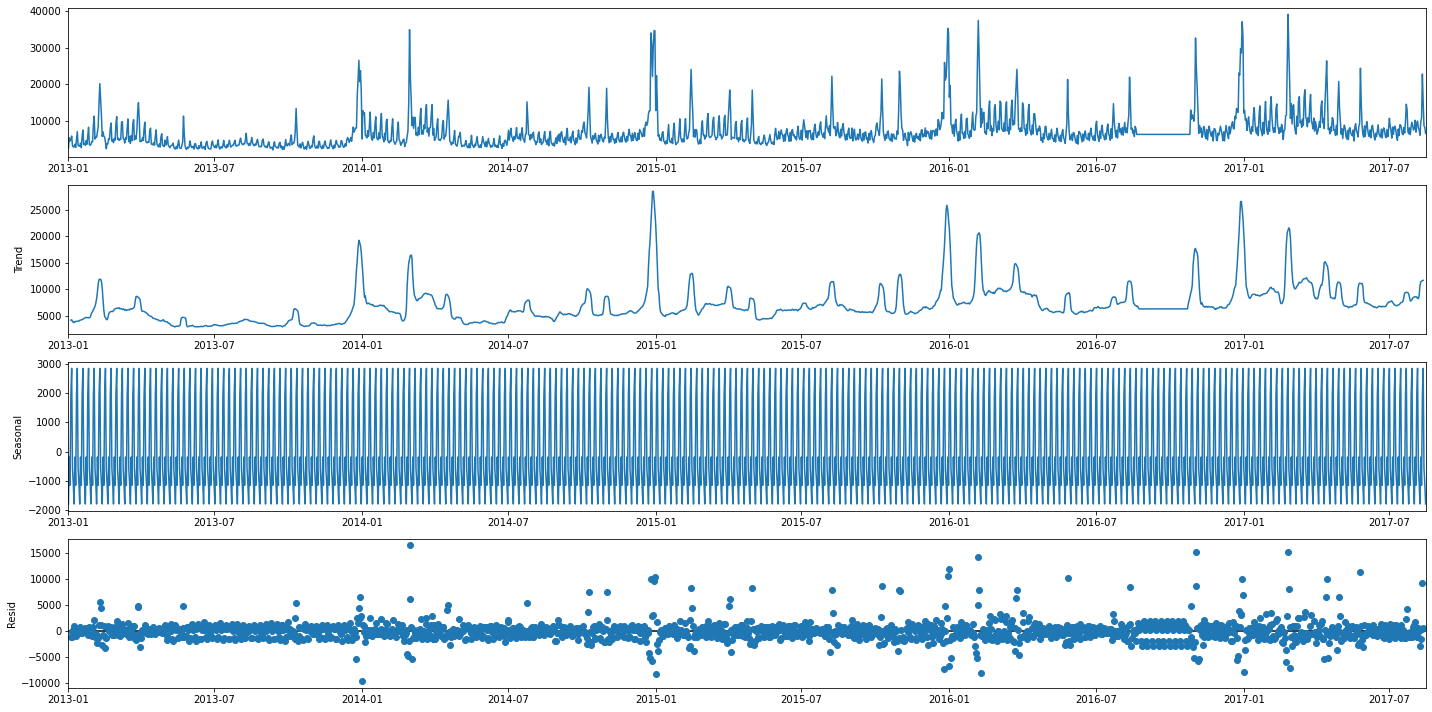

In [38]:
# применяем seasonal_decompose
# эта функция разложит ряд на трендовую, сезонную и шумовую составляющие
decomposition = seasonal_decompose(_gdf25, model='additive') 
decomposition.plot()
pyplot.show() # любуемся результатом

In [39]:
trend_part = decomposition.trend # отдельно трендовая составляющаяя
seasonal_part = decomposition.seasonal # отдельно сезонная составляющаяя
residual_part = decomposition.resid # отдельно шум: то, что осталось

In [40]:
# вначале и в конце есть наны
trend_part

date
2013-01-01             NaN
2013-01-02             NaN
2013-01-03             NaN
2013-01-04     4131.187000
2013-01-05     4184.424857
                  ...     
2017-08-11    11603.052429
2017-08-12    11674.160857
2017-08-13             NaN
2017-08-14             NaN
2017-08-15             NaN
Freq: D, Name: trend, Length: 1688, dtype: float64

In [41]:
# вначале и в конце есть наны
residual_part

date
2013-01-01            NaN
2013-01-02            NaN
2013-01-03            NaN
2013-01-04   -1211.081315
2013-01-05   -1213.923016
                 ...     
2017-08-11    9273.540256
2017-08-12     569.567984
2017-08-13            NaN
2017-08-14            NaN
2017-08-15            NaN
Freq: D, Name: resid, Length: 1688, dtype: float64

In [42]:
# (здесь нет нанов в конце и в начале)
seasonal_part

date
2013-01-01   -1787.406986
2013-01-02    -183.247043
2013-01-03   -1146.441127
2013-01-04    1924.248315
2013-01-05    2847.024159
                 ...     
2017-08-11    1924.248315
2017-08-12    2847.024159
2017-08-13    -570.849326
2017-08-14   -1083.327992
2017-08-15   -1787.406986
Freq: D, Name: seasonal, Length: 1688, dtype: float64

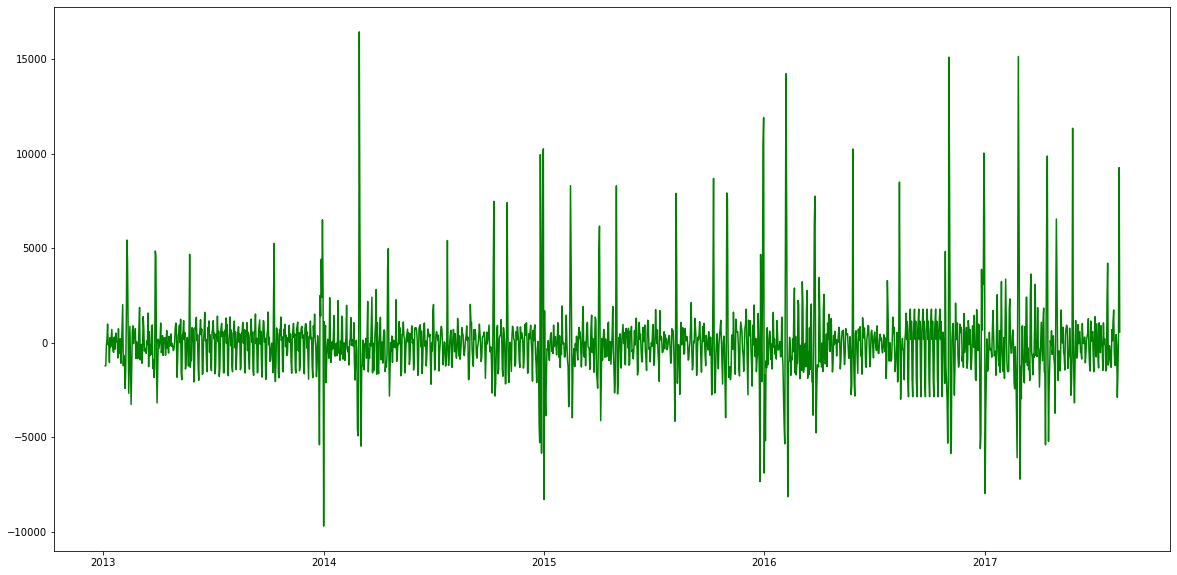

In [43]:
plt.plot(residual_part, "g", label="Res")


In [44]:
# в конце и в начале стоят значения NaN. Это связано с особенностями алгоритма seasonal_decompose
# если мы хотим далее анализировать остатки, необходимо избавиться от этих некорректных значений
trend_part=trend_part.dropna()
residual_part = residual_part.dropna()


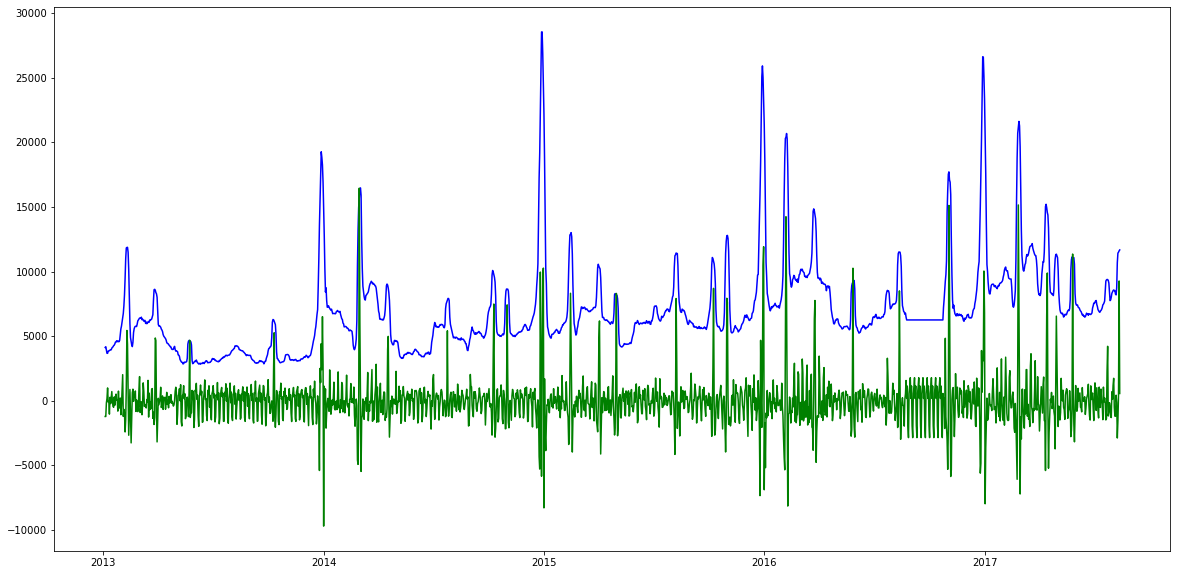

In [45]:
residual_part.head()
plt.plot(trend_part,"b")
plt.plot(residual_part, "g")

In [50]:
trend_part

date
2013-01-04     4131.187000
2013-01-05     4184.424857
2013-01-06     3934.341286
2013-01-07     3681.630000
2013-01-08     3674.457714
                  ...     
2017-08-08    10688.090571
2017-08-09    11428.196000
2017-08-10    11500.551571
2017-08-11    11603.052429
2017-08-12    11674.160857
Freq: D, Name: trend, Length: 1682, dtype: float64

In [51]:
#продолжить декомпозицию трендовой составляющей
df25next=trend_part.to_frame(name='unit_sales')
df25next

,unit_sales
date,
2013-01-04,4131.187000
2013-01-05,4184.424857
2013-01-06,3934.341286
2013-01-07,3681.630000
2013-01-08,3674.457714
...,...
2017-08-08,10688.090571
2017-08-09,11428.196000
2017-08-10,11500.551571


In [53]:
df25next.index

DatetimeIndex(['2013-01-04', '2013-01-05', '2013-01-06', '2013-01-07',
               '2013-01-08', '2013-01-09', '2013-01-10', '2013-01-11',
               '2013-01-12', '2013-01-13',
               ...
               '2017-08-03', '2017-08-04', '2017-08-05', '2017-08-06',
               '2017-08-07', '2017-08-08', '2017-08-09', '2017-08-10',
               '2017-08-11', '2017-08-12'],
              dtype='datetime64[ns]', name='date', length=1682, freq='D')

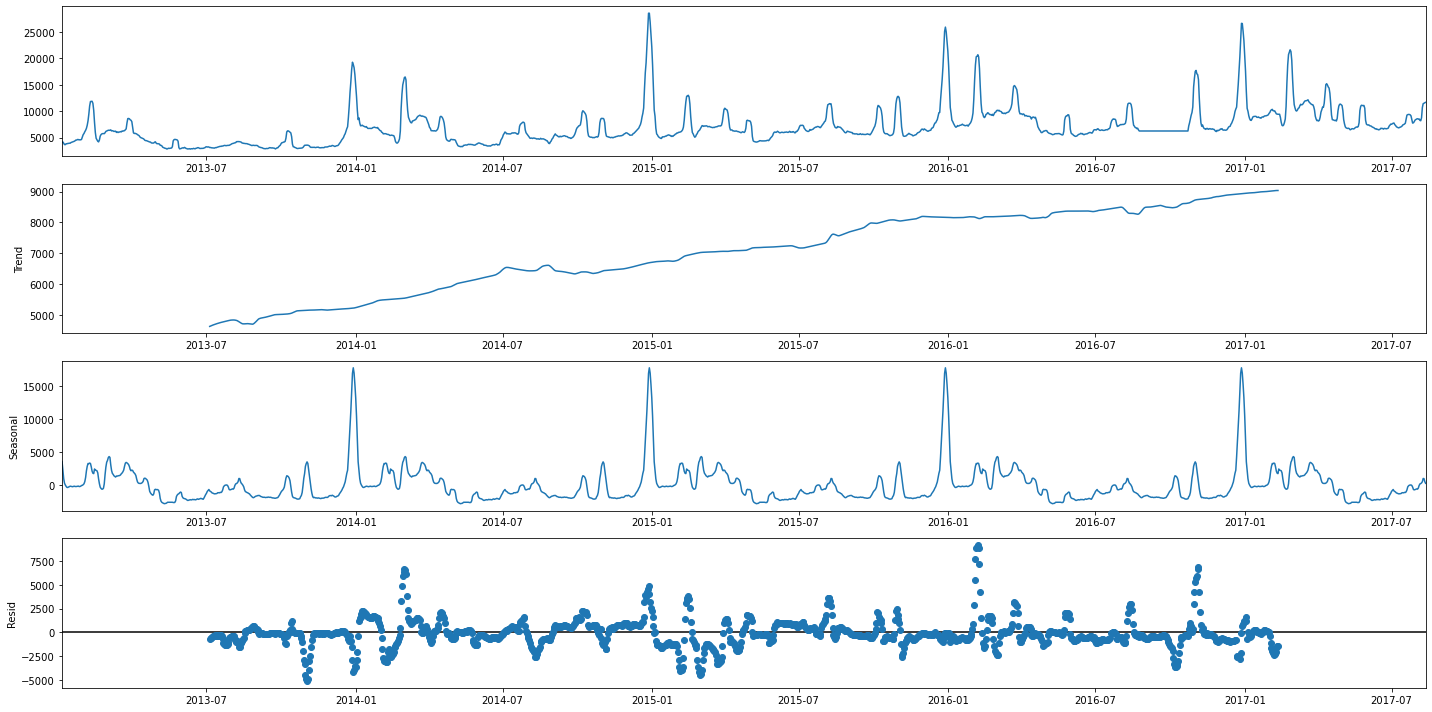

In [54]:
#очевидно seasonal_decompose нашел "ежедневную сезонность", а осталась еще годовая и возможно квартальная
decomposition = seasonal_decompose(df25next, model='additive',period=365) 
decomposition.plot()
pyplot.show() 

In [ ]:
#теперь тренд более гладко выражен

In [56]:
trend_part = decomposition.trend # отдельно трендовая составляющаяя
seasonal_part = decomposition.seasonal # отдельно сезонная составляющаяя
residual_part = decomposition.resid # отдельно шум: то, что осталось
trend_part=trend_part.dropna() 
residual_part=residual_part.dropna()


1 date
2013-01-04   NaN
2013-01-05   NaN
2013-01-06   NaN
2013-01-07   NaN
2013-01-08   NaN
              ..
2017-08-08   NaN
2017-08-09   NaN
2017-08-10   NaN
2017-08-11   NaN
2017-08-12   NaN
Freq: D, Name: resid, Length: 1682, dtype: float64
2 date
2013-07-05    -659.281642
2013-07-06    -570.439958
2013-07-07    -556.568434
2013-07-08    -440.066831
2013-07-09    -439.572176
                 ...     
2017-02-07   -2285.124039
2017-02-08   -2057.875198
2017-02-09   -1690.709431
2017-02-10   -1414.592251
2017-02-11   -1393.145196
Freq: D, Name: resid, Length: 1318, dtype: float64


In [57]:
#ответ на вопрос в задании - сколько элементов содержат части:
print('residual_part:',residual_part.shape,'trend_part',trend_part.shape,'seasonal_part',seasonal_part.shape)

residual_part: (1318,) trend_part (1318,) seasonal_part (1682,)


Анализ результата:

В ряде явно присутствует тренд на рост и ярко выражена годовая сезонность

Остатки ряда содержат какие-то всплески, возможно, все еще содержат закономерности

In [58]:
#если не заполнять пропуски индекса, то можно указать период seasonal_decompose и тоже срабатывает
gdf26=gdf25[['unit_sales']]
gdf26

,unit_sales
date,
2013-01-01,2511.619
2013-01-02,5316.224
2013-01-03,4442.913
2013-01-04,4844.354
2013-01-05,5817.526
...,...
2017-08-11,22800.841
2017-08-12,15090.753
2017-08-13,8570.598


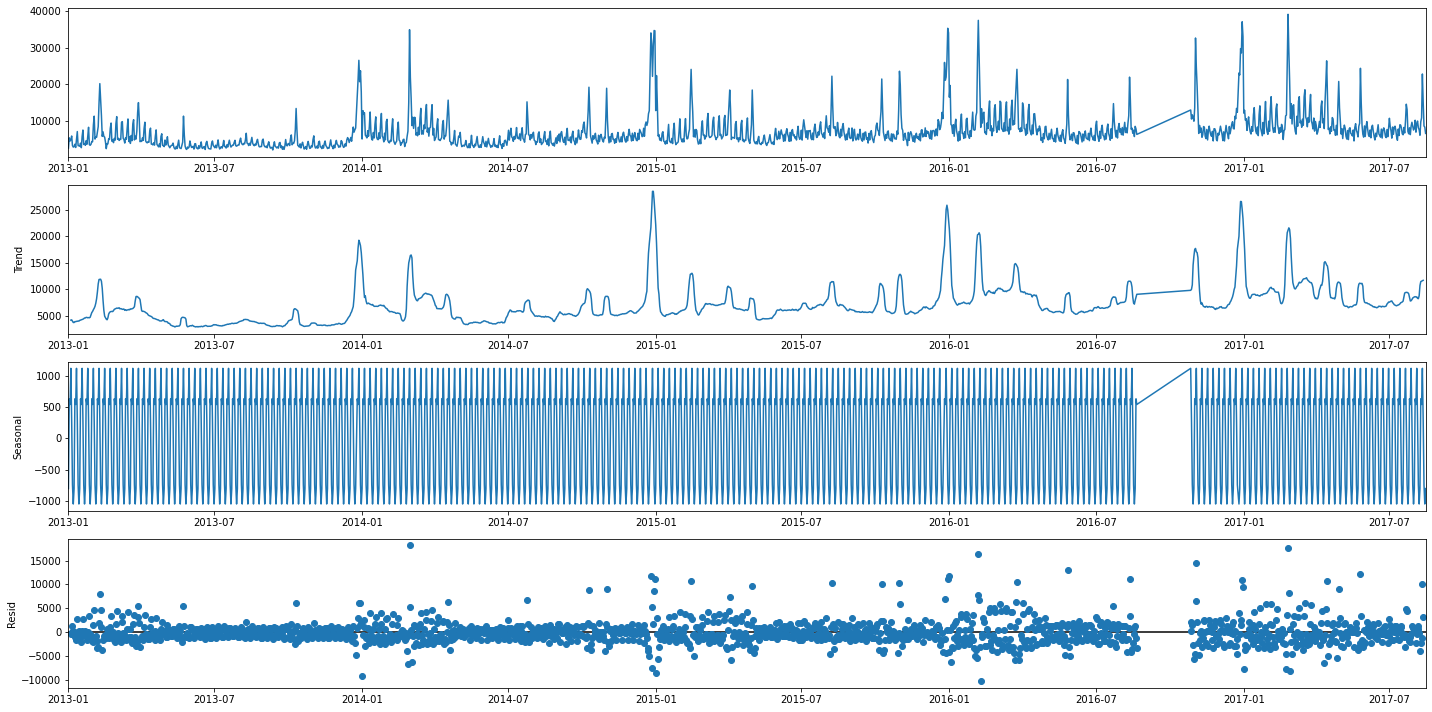

In [59]:
decomposition = seasonal_decompose(gdf26, model='additive',period=7) 
decomposition.plot()
pyplot.show() #для семидневного периода всплески пока остаются

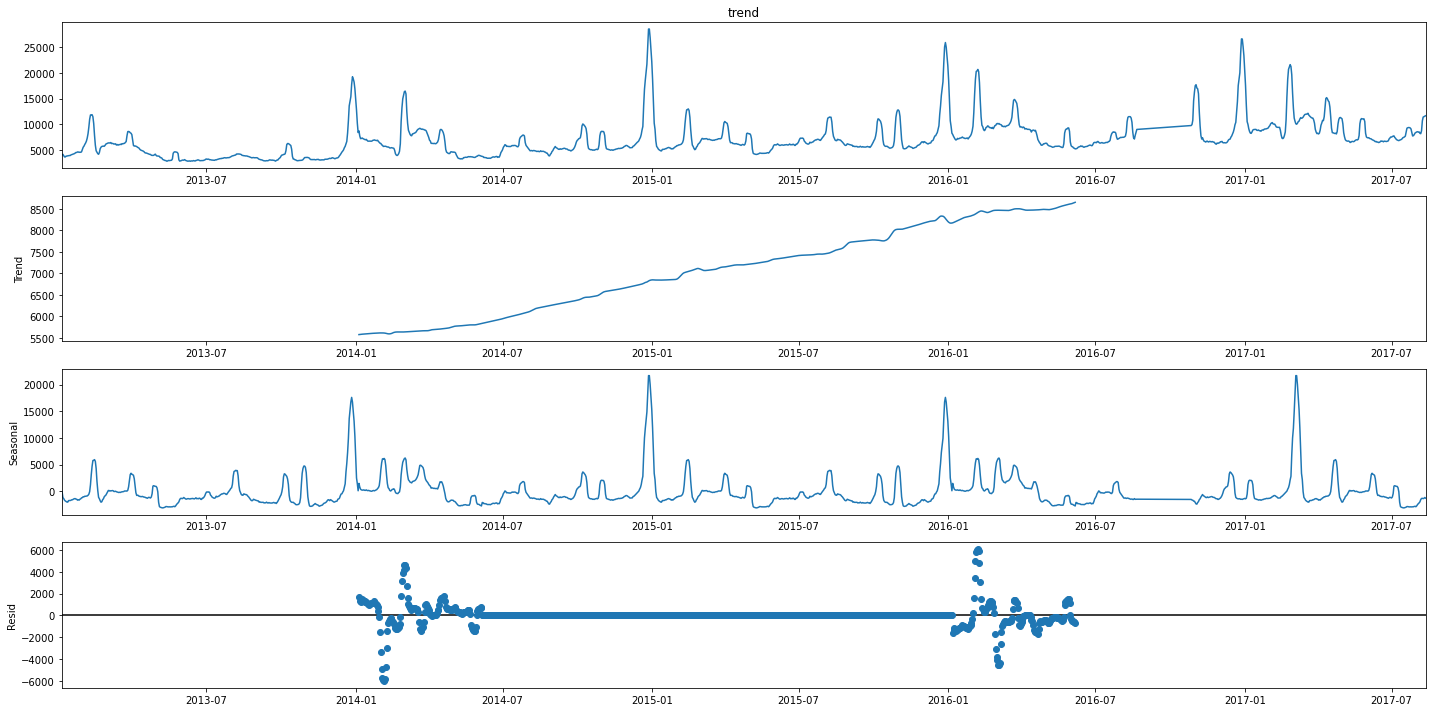

In [219]:
trend_part = decomposition.trend.dropna()

decomposition = seasonal_decompose(trend_part, model='additive',period=365*2) 
decomposition.plot()
pyplot.show() #для двугодичного периода уже тренд гладкий

In [ ]:
#в итоге пока у меня нет понимания, какой вариант выбора периодов оказался эффективнее(
#(ежедневный,годовой, 
# или
# недельный, двухгодовой)

In [60]:
_gdf25

,unit_sales
date,
2013-01-01,2511.619
2013-01-02,5316.224
2013-01-03,4442.913
2013-01-04,4844.354
2013-01-05,5817.526
...,...
2017-08-11,22800.841
2017-08-12,15090.753
2017-08-13,8570.598


In [63]:
#тест Дики-фуллера:
from statsmodels.tsa.stattools import adfuller


In [62]:
def testStationarity(ts):
    dftest = adfuller(ts)
    # Семантическое описание значения, полученного вышеуказанной функцией
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput
testStationarity(_gdf25['unit_sales'])
    

Test Statistic                   -5.079730
p-value                           0.000015
#Lags Used                       25.000000
Number of Observations Used    1662.000000
Critical Value (1%)              -3.434291
Critical Value (5%)              -2.863281
Critical Value (10%)             -2.567697
dtype: float64

In [ ]:
#меленькое значение p-value - это аргумент в пользу того, что ряд может быть стационарным

In [65]:
from sklearn.model_selection import TimeSeriesSplit
tscv=TimeSeriesSplit(n_splits=3,test_size=7)


In [123]:
#размеры полученных подвыборок, сформированных специальным сплиттером для временных рядов:
for train_index, test_index in tscv.split(_gdf25):
    print("TRAIN:", train_index, type(train_index),"TEST:", test_index)
    X_train, X_test = _gdf25.index[train_index], _gdf25.index[test_index]
    y_train, y_test = _gdf25['unit_sales'][train_index], _gdf25['unit_sales'][test_index]
    print("TRAIN:", train_index.shape, "TEST:", test_index.shape)

TRAIN: [   0    1    2 ... 1664 1665 1666] <class 'numpy.ndarray'> TEST: [1667 1668 1669 1670 1671 1672 1673]
TRAIN: (1667,) TEST: (7,)
TRAIN: [   0    1    2 ... 1671 1672 1673] <class 'numpy.ndarray'> TEST: [1674 1675 1676 1677 1678 1679 1680]
TRAIN: (1674,) TEST: (7,)
TRAIN: [   0    1    2 ... 1678 1679 1680] <class 'numpy.ndarray'> TEST: [1681 1682 1683 1684 1685 1686 1687]
TRAIN: (1681,) TEST: (7,)


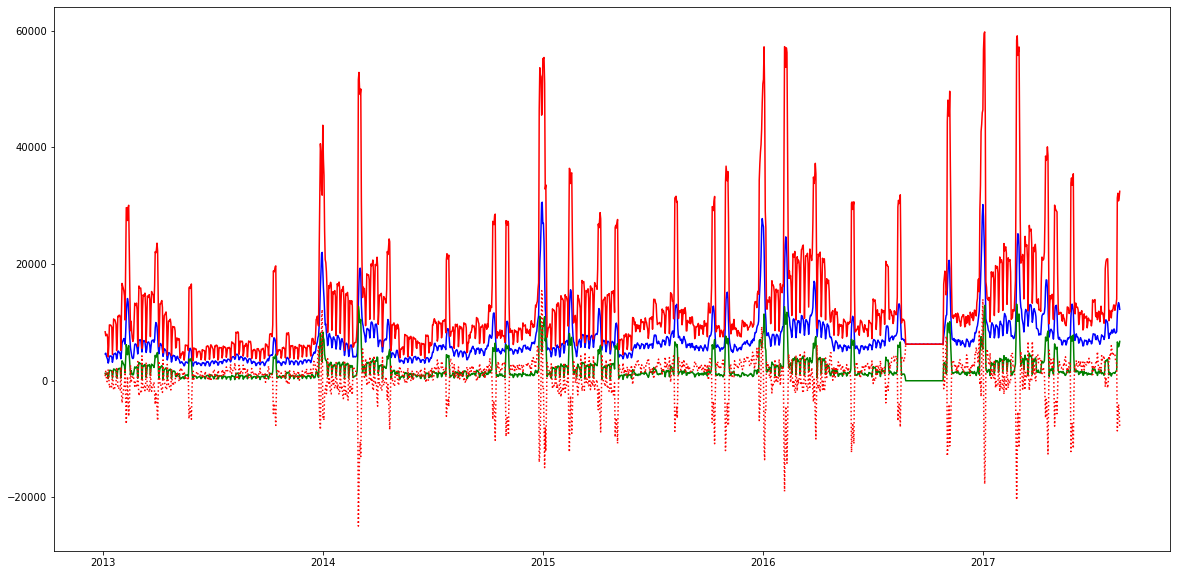

In [70]:
_gdf25['rolling_mean']=_gdf25.unit_sales.rolling(window=5).mean()
_gdf25['rolling_std']=_gdf25.unit_sales.rolling(window=5).std()
_gdf25['up_bollindger']=_gdf25['rolling_mean']+3*_gdf25['rolling_std']
_gdf25['down_bollindger']=_gdf25['rolling_mean']-3*_gdf25['rolling_std']
plt.plot(_gdf25['rolling_mean'],"b")
plt.plot(_gdf25['rolling_std'],"g")
plt.plot(_gdf25['down_bollindger'],"r:")
plt.plot(_gdf25['up_bollindger'],"r-")

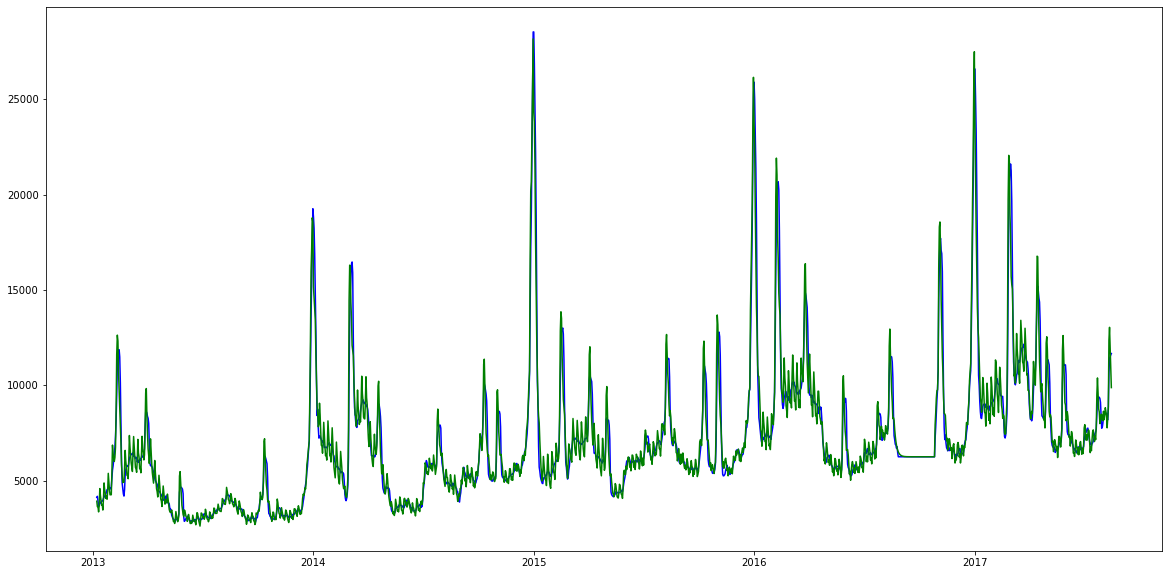

In [73]:
N=7
## делаем оконное среднее с окном в N точек
_gdf25['rolling_mean' + str(N)] = _gdf25.unit_sales.rolling(window=N).mean()
## экспоненциально среднее с окном в N точек
_gdf25['rolling_ema' + str(N)] = _gdf25.unit_sales.ewm(min_periods=N, span=N).mean()
plt.plot(_gdf25['rolling_mean'+ str(N)],"b")
plt.plot(_gdf25['rolling_ema' + str(N)],"g")

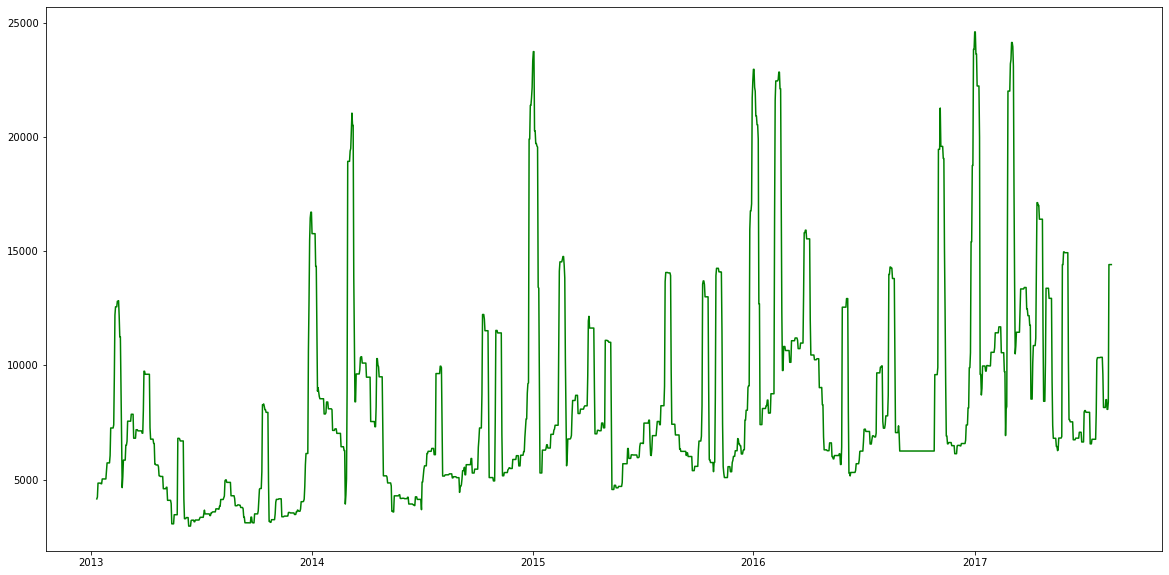

In [74]:
def minmaxmean(x):
    return (x.max()+x.min())/2
_gdf25['rolling_minmaxmean']=_gdf25.unit_sales.rolling(window=10).apply(minmaxmean)
plt.plot(_gdf25['rolling_minmaxmean'],"g")

In [77]:
N,n=50,10
_gdf25[f'rolling_mean{N}'] = _gdf25.unit_sales.rolling(window=N).mean()
_gdf25[f'rolling_ema{n}'] = _gdf25.unit_sales.ewm(min_periods=n, span=n).mean()
_gdf25['rolling_npsign']=(_gdf25[f'rolling_mean{N}']-_gdf25[f'rolling_ema{n}']).apply(np.sign)
_gdf25['rolling_npsign']

date
2013-01-01    NaN
2013-01-02    NaN
2013-01-03    NaN
2013-01-04    NaN
2013-01-05    NaN
             ... 
2017-08-11   -1.0
2017-08-12   -1.0
2017-08-13   -1.0
2017-08-14   -1.0
2017-08-15   -1.0
Freq: D, Name: rolling_npsign, Length: 1688, dtype: float64

In [81]:
#разница между соседними рядами
_gdf25['diff']=_gdf25['rolling_npsign'].diff()
_gdf25


,unit_sales,rolling_mean,rolling_std,up_bollindger,down_bollindger,rolling_mean_7,rolling_ema_7,rolling_mean7,rolling_ema7,rolling_minmaxmean,rolling_mean50,rolling_ema10,rolling_npsign,diff
date,,,,,,,,,,,,,,
2013-01-01,2511.619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,5316.224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,4442.913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,4844.354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-05,5817.526,4586.5272,1268.873437,8393.147512,779.906888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,22800.841,11368.5020,6654.095169,31330.787508,-8593.783508,10688.090571,12367.981578,10688.090571,12367.981578,14412.935,8208.22576,11294.195768,-1.0,0.0
2017-08-12,15090.753,12881.1830,6418.091607,32135.457822,-6373.091822,11428.196000,13048.674434,11428.196000,13048.674434,14412.935,8361.01972,11984.478901,-1.0,0.0
2017-08-13,8570.598,13390.2968,5810.462774,30821.685121,-4041.091521,11500.551571,11929.155325,11500.551571,11929.155325,14412.935,8371.36112,11363.773283,-1.0,0.0


In [84]:
#выбрать только ряды, где пересекаются графики mean(окно50) и ewm(окно10) для unit_sales
_gdf25.query('diff!=0')

,unit_sales,rolling_mean,rolling_std,up_bollindger,down_bollindger,rolling_mean_7,rolling_ema_7,rolling_mean7,rolling_ema7,rolling_minmaxmean,rolling_mean50,rolling_ema10,rolling_npsign,diff
date,,,,,,,,,,,,,,
2013-01-01,2511.619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,5316.224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,4442.913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,4844.354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-05,5817.526,4586.5272,1268.873437,8393.147512,779.906888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-03,9753.867,7606.0048,1903.731211,13317.198432,1894.811168,7575.017000,8618.536017,7575.017000,8618.536017,14932.9700,8585.84160,8718.771233,-1.0,-2.0
2017-06-05,6086.761,7537.8716,1691.113048,12611.210744,2464.532456,7396.160000,7805.179572,7396.160000,7805.179572,10161.3825,8375.11050,8082.175552,1.0,2.0
2017-07-02,8452.498,8058.7770,1814.633910,13502.678729,2614.875271,7345.575429,7943.149213,7345.575429,7943.149213,8027.1110,7557.49456,7655.745634,-1.0,-2.0


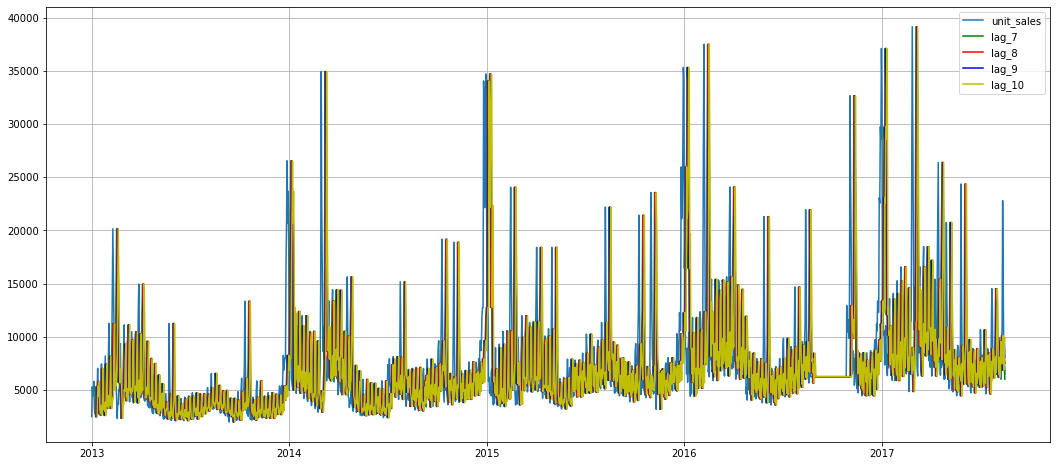

In [85]:
#Лаги 7,8,9,10
for i in range(7,11):
    _gdf25['lag_{}'.format(i)] = _gdf25.unit_sales.shift(i)


## визуализируем
f, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(_gdf25.unit_sales) ## исходные данные
clr=['g','r','b','y']
for i,clr_ in zip(range(7,11),clr):
    ax.plot(_gdf25[f'lag_{i}'],  c=clr_) 
ax.legend(['unit_sales', 'lag_7', 'lag_8', 'lag_9', 'lag_10'])
ax.grid()

In [87]:
%%time

#грузить этот сет не надо, он облегчен и надо грузить только выборку для магазина 103501 ниже
df=pd.read_csv(f'{DIR}train.csv',sep=',',decimal='.',parse_dates=['date'])

#работа с другой выборкой:
df11=df[df.item_nbr==103501]

df11.to_csv(f'{DIR}train103501.csv',index=False)
df11.info()

c:\Users\User\anaconda3\lib\site-packages\IPython\core\magics\execution.py:1324: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code, glob, local_ns)


Wall time: 7min 54s


In [136]:
df11=pd.read_csv(f'{DIR}train103501.csv')
df11

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,9389,2013-01-02,9,103501,19.0,NaN
1,10410,2013-01-02,10,103501,8.0,NaN
2,11087,2013-01-02,11,103501,13.0,NaN
3,12049,2013-01-02,12,103501,7.0,NaN
4,12764,2013-01-02,13,103501,13.0,NaN
...,...,...,...,...,...,...
35836,125455877,2017-08-15,36,103501,5.0,False
35837,125461838,2017-08-15,39,103501,3.0,False
35838,125463851,2017-08-15,40,103501,10.0,False
35839,125469358,2017-08-15,43,103501,3.0,False


In [137]:
gdf11=df11[['date','unit_sales']].groupby(['date']).sum()
gdf11.head()

,unit_sales
date,
2013-01-02,185.0
2013-01-03,153.0
2013-01-04,155.0
2013-01-05,160.0
2013-01-06,173.0


In [138]:
#adfuller test
testStationarity(gdf11['unit_sales'])

Test Statistic                   -4.154403
p-value                           0.000786
#Lags Used                       25.000000
Number of Observations Used    1599.000000
Critical Value (1%)              -3.434446
Critical Value (5%)              -2.863349
Critical Value (10%)             -2.567733
dtype: float64

In [139]:
#меленькое значение p-value - это аргумент в пользу того, что ряд может быть стационарным

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
#Модель скользящего среднего:
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)
moving_average_days = 6
moving_avg = moving_average_forecast(gdf11,moving_average_days )# 

print(moving_avg.shape,gdf11.shape)

print("mean_squared_error",mean_squared_error(gdf11.values[moving_average_days:], moving_avg))
print("mean_absolute_error",mean_absolute_error(gdf11.values[moving_average_days:], moving_avg))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(gdf11.values[moving_average_days:], moving_avg))


(1619, 1) (1625, 1)
mean_squared_error 1139.483889232036
mean_absolute_error 26.661828289067326
mean_absolute_percentage_error 0.326732641949257


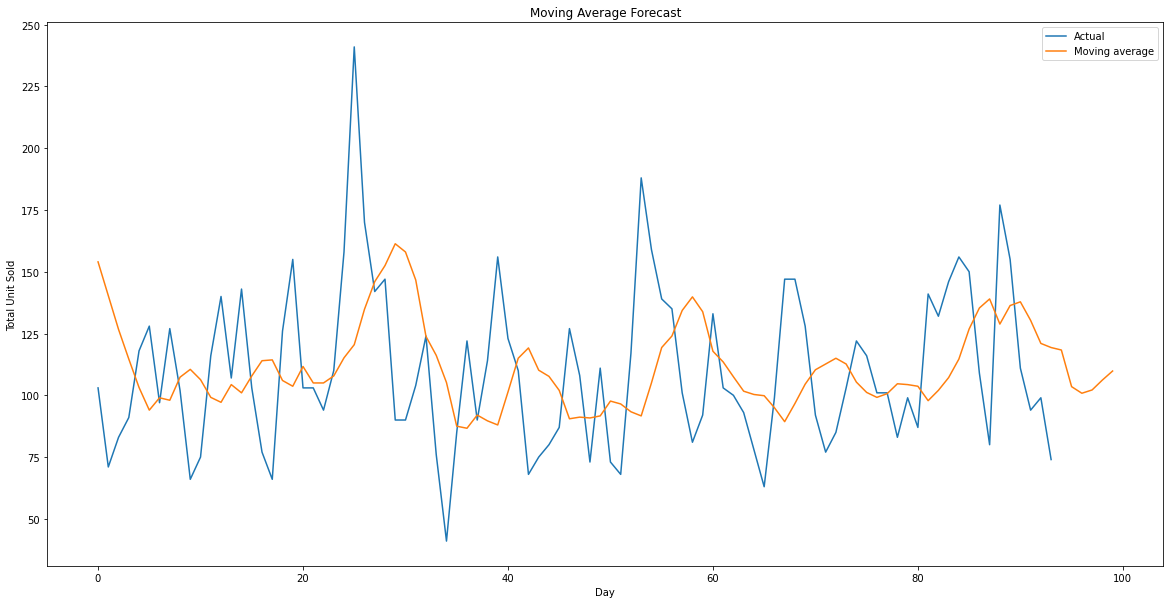

In [140]:
plt.plot(gdf11.values[moving_average_days:100], label="Actual")
plt.plot(moving_avg[:100], label="Moving average")
plt.ylabel("Total Unit Sold")
plt.xlabel("Day")
plt.title("Moving Average Forecast")
plt.legend(loc="upper right")

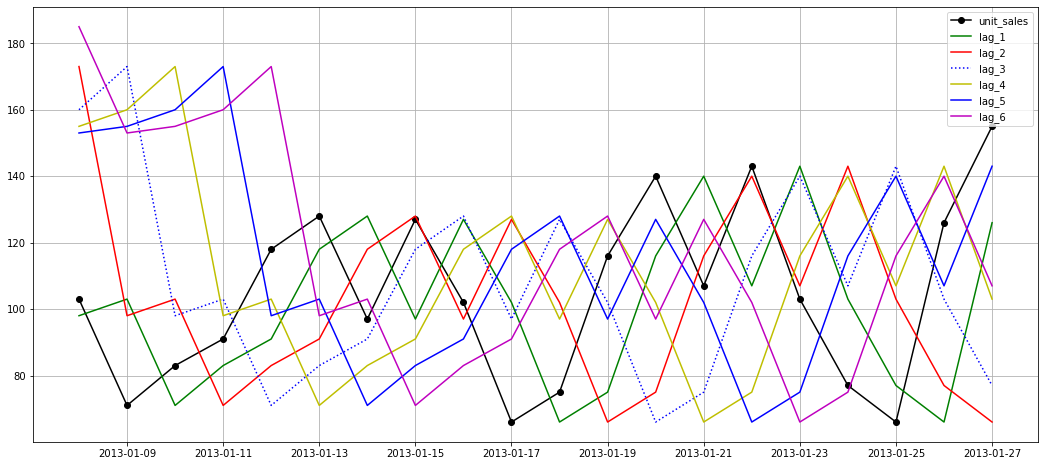

In [146]:
for i in range(1,7):
    gdf11['lag_{}'.format(i)] = gdf11.unit_sales.shift(i)
gdf11.dropna(inplace=True)    


## визуализируем
f, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(gdf11.unit_sales[:20],'ko-') ## исходные данные
clr=['g','r','b:','y','b-','m']
for i,clr_ in zip(range(1,7),clr):
    ax.plot(gdf11[f'lag_{i}'][:20],  clr_) 
ax.legend(['unit_sales', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6'])
ax.grid()

In [215]:
gdf11 = gdf11.set_index(pd.DatetimeIndex(gdf11.index))
gdf11.index

DatetimeIndex(['2013-01-08', '2013-01-09', '2013-01-10', '2013-01-11',
               '2013-01-12', '2013-01-13', '2013-01-14', '2013-01-15',
               '2013-01-16', '2013-01-17',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', name='date', length=1619, freq=None)

In [148]:
#индекс ряда, которым начинается 2017 год
sgaps=gdf11.index.get_loc(gdf11['2017'].iloc[0].name)
sgaps

1393

In [160]:
#т.о. индексы тренировочной и тестовой выборки будут:
train_index,test_index=np.array(list(range(sgaps))),np.array(list(range(sgaps,len(gdf11.index))))

print("index  TRAIN:", train_index, "TEST:", test_index)
X_train, X_test = gdf11.iloc[:sgaps].iloc[:,1:].values, gdf11.iloc[sgaps:].iloc[:,1:].values
y_train, y_test = gdf11['unit_sales'].iloc[:sgaps].values,gdf11['unit_sales'].iloc[sgaps:].values
print("values TEST:", X_test,y_test)

index  TRAIN: [   0    1    2 ... 1390 1391 1392] TEST: [1393 1394 1395 1396 1397 1398 1399 1400 1401 1402 1403 1404 1405 1406
 1407 1408 1409 1410 1411 1412 1413 1414 1415 1416 1417 1418 1419 1420
 1421 1422 1423 1424 1425 1426 1427 1428 1429 1430 1431 1432 1433 1434
 1435 1436 1437 1438 1439 1440 1441 1442 1443 1444 1445 1446 1447 1448
 1449 1450 1451 1452 1453 1454 1455 1456 1457 1458 1459 1460 1461 1462
 1463 1464 1465 1466 1467 1468 1469 1470 1471 1472 1473 1474 1475 1476
 1477 1478 1479 1480 1481 1482 1483 1484 1485 1486 1487 1488 1489 1490
 1491 1492 1493 1494 1495 1496 1497 1498 1499 1500 1501 1502 1503 1504
 1505 1506 1507 1508 1509 1510 1511 1512 1513 1514 1515 1516 1517 1518
 1519 1520 1521 1522 1523 1524 1525 1526 1527 1528 1529 1530 1531 1532
 1533 1534 1535 1536 1537 1538 1539 1540 1541 1542 1543 1544 1545 1546
 1547 1548 1549 1550 1551 1552 1553 1554 1555 1556 1557 1558 1559 1560
 1561 1562 1563 1564 1565 1566 1567 1568 1569 1570 1571 1572 1573 1574
 1575 1576 1577 1578 

In [161]:
X_test.shape

(226, 6)

[ 0.65082231 -0.05879179 -0.02734075 -0.01144045 -0.0576629   0.31276881]
19.07113258579578
mean_squared_error 907.1733977063598
mean_absolute_error 22.858131609015366
mean_absolute_percentage_error 0.2060459359095241


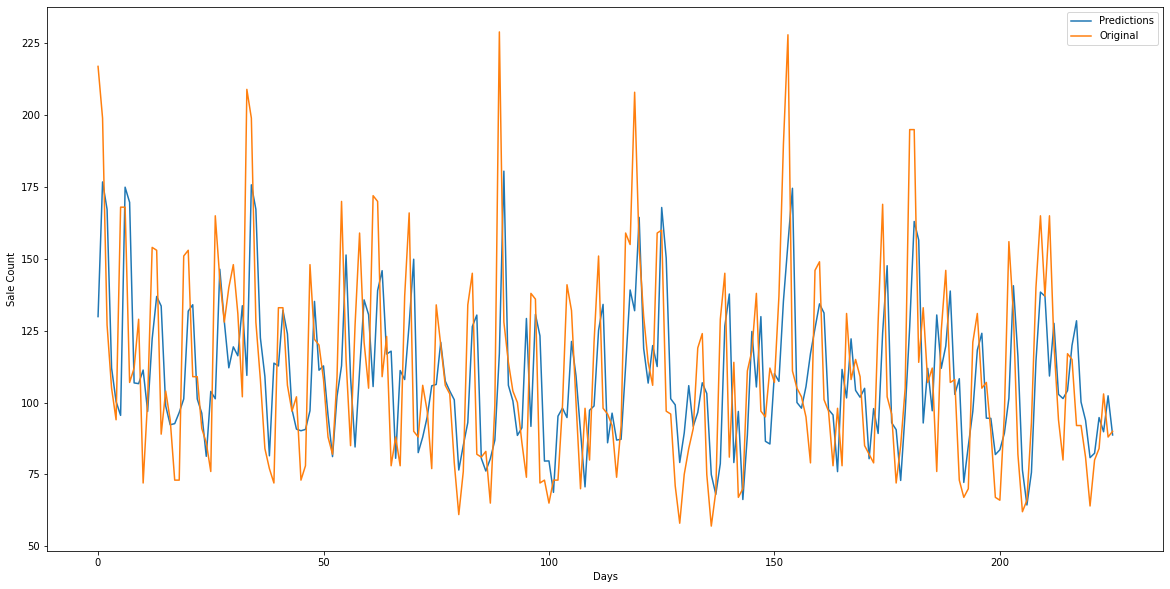

In [162]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
print(reg.coef_)
print(reg.intercept_)


ar_predictions = reg.predict(X_test)

plt.plot(ar_predictions ,label = "Predictions")
plt.plot(y_test, label = "Original" )
plt.xlabel("Days")
plt.ylabel("Sale Count")

print("mean_squared_error",mean_squared_error(y_test, ar_predictions))
print("mean_absolute_error",mean_absolute_error(y_test, ar_predictions))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, ar_predictions))


plt.legend(loc="upper right")

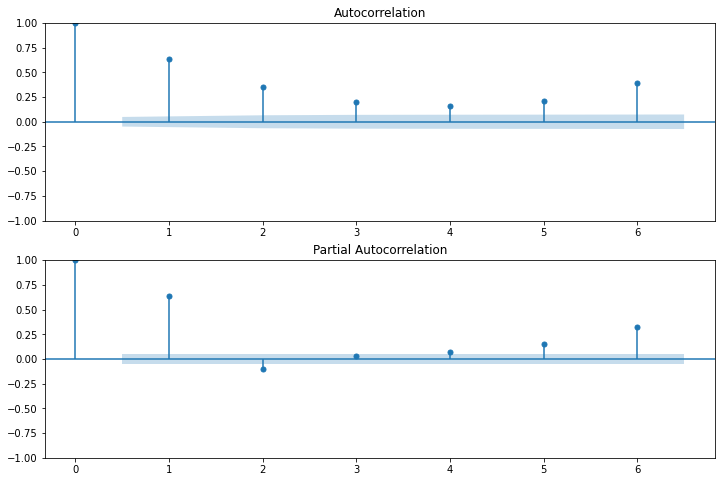

In [163]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(gdf11['unit_sales'].values, lags=6, ax=ax1) #.squeeze()
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(gdf11['unit_sales'], lags=6, ax=ax2)

In [ ]:
p=6 #на ACF все коэф. отличны от нуля
q=6 #на PACF шестой койэф. является максимальным, при котором значение функции сильнее возрастает

In [166]:
X_train.reshape(-1)

array([ 98., 173., 160., ..., 116., 148., 103.])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

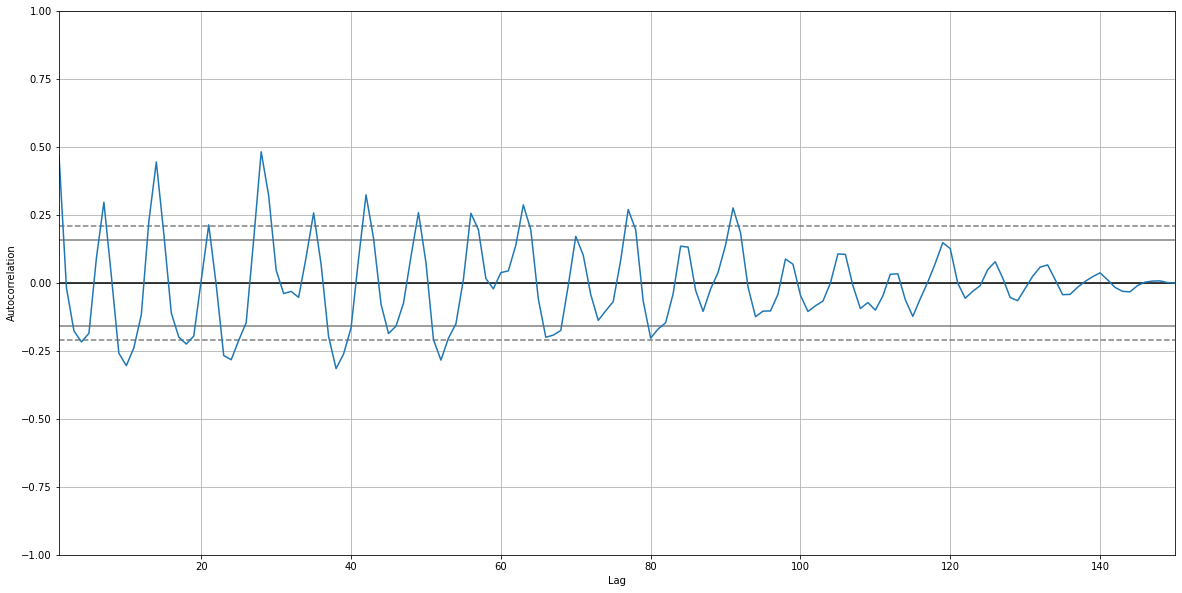

In [174]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(gdf11['unit_sales'].iloc[:150])

In [175]:
sdf11=gdf11['unit_sales']
sdf11.index

DatetimeIndex(['2013-01-08', '2013-01-09', '2013-01-10', '2013-01-11',
               '2013-01-12', '2013-01-13', '2013-01-14', '2013-01-15',
               '2013-01-16', '2013-01-17',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', name='date', length=1619, freq=None)

In [176]:
sdf11.index = sdf11.index.to_period('D')
sdf11.index

PeriodIndex(['2013-01-08', '2013-01-09', '2013-01-10', '2013-01-11',
             '2013-01-12', '2013-01-13', '2013-01-14', '2013-01-15',
             '2013-01-16', '2013-01-17',
             ...
             '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
             '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
             '2017-08-14', '2017-08-15'],
            dtype='period[D]', name='date', length=1619)

In [185]:
type(sdf11)

pandas.core.series.Series

c:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\User\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1393
Model:                 ARIMA(6, 0, 6)   Log Likelihood               -6318.147
Date:                Fri, 29 Jul 2022   AIC                          12664.295
Time:                        16:08:22   BIC                          12737.644
Sample:                             0   HQIC                         12691.721
                               - 1393                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         99.5923      7.397     13.463      0.000      85.094     114.091
ar.L1          0.7661      0.032     23.976      0.000       0.703       0.829
ar.L2         -0.4826      0.044    -10.900      0.0

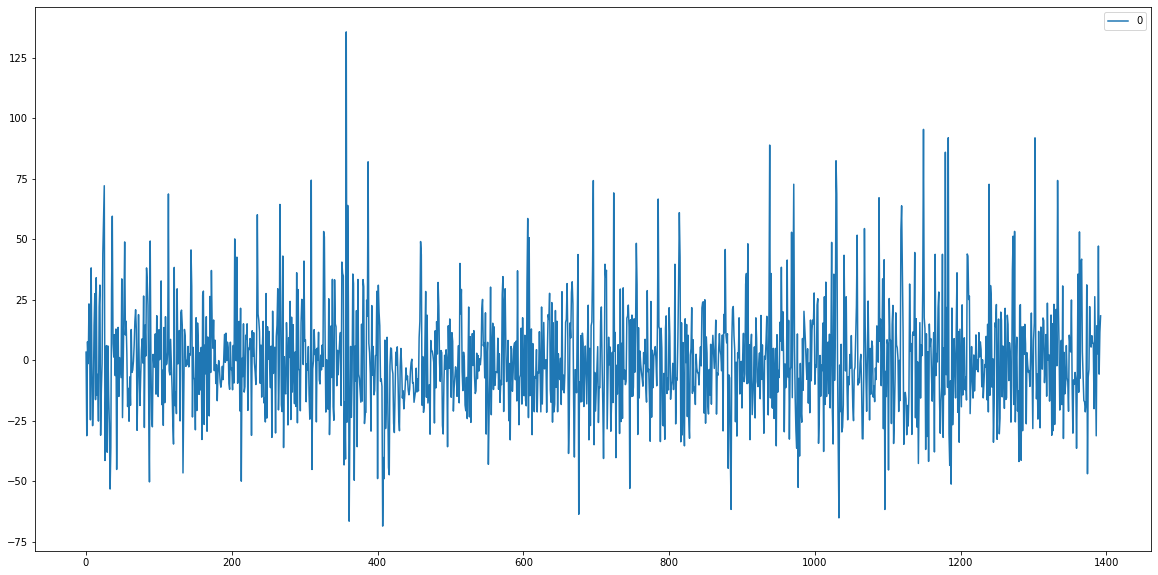

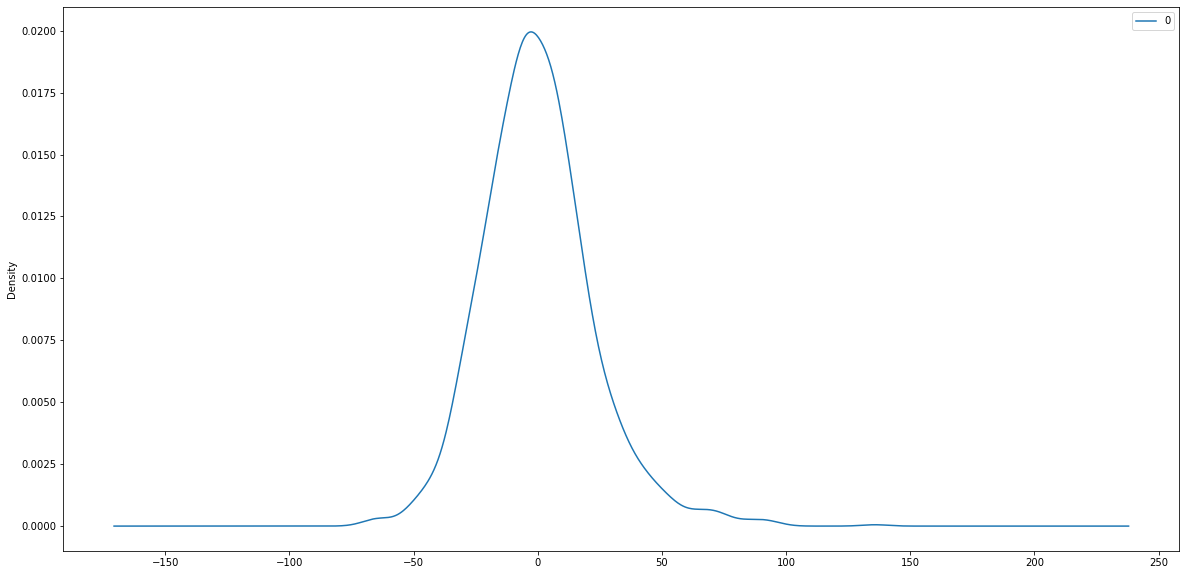

                 0
count  1393.000000
mean      0.049000
std      22.498553
min     -68.496243
25%     -14.573023
50%      -1.616789
75%      11.776063
max     135.795434


In [186]:
#ARMA Model
import statsmodels.api as sm
# from statsmodels.tsa.arima_model import ARMA
from datetime import datetime, timedelta

#использовать новую бибилиотеку вместо arima_model
from statsmodels.tsa.arima.model import ARIMA

# тестовая и тренировочная выборки определены ранее
# X_train, X_test = gdf11.iloc[:sgaps].iloc[:,1:].values, gdf11.iloc[sgaps:].iloc[:,1:].values
# y_train, y_test = gdf11['unit_sales'].iloc[:sgaps].values,gdf11['unit_sales'].iloc[sgaps:].values
# X_train, X_test = gdf11.iloc[:sgaps].iloc[:,0].values, gdf11.iloc[sgaps:].iloc[:,0].values
# y_train, y_test = gdf11['unit_sales'].iloc[:sgaps].values,gdf11['unit_sales'].iloc[sgaps:].values

X_train, X_test=sdf11.iloc[:sgaps].values,sdf11.iloc[sgaps:].values
#в качестве ARMA принимается arima с нулевым параметром d
ARMA_model = ARIMA(X_train, order=(6,0, 6)).fit()

# summary of fit model
print(ARMA_model.summary())
# line plot of residuals
residuals = pd.DataFrame(ARMA_model.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())


In [187]:
predictions = ARMA_model.predict(start=len(X_train), end=len(X_train) + len(X_test)-1, dynamic=False)

#forecast очень медленно работает, если для всего набора тест

# history = [x for x in X_train ]
# predictions = list()
# # walk-forward validation
# for t in range(10): #
# 	model = ARIMA(history, order=(6,0,6))
# 	model_fit = model.fit()
# 	output = model_fit.forecast()
# 	yhat = output[0]
# 	predictions.append(yhat)
# 	obs = X_test[t]
# 	history.append(obs)
# 	print('predicted=%f, expected=%f' % (yhat, obs))
# # evaluate forecasts
print("mean_squared_error",mean_squared_error(X_test, predictions))
print("mean_absolute_error",mean_absolute_error(X_test, predictions))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(X_test, predictions))


mean_squared_error 1531.620051093782
mean_absolute_error 29.927933535704415
mean_absolute_percentage_error 0.25859186608810764


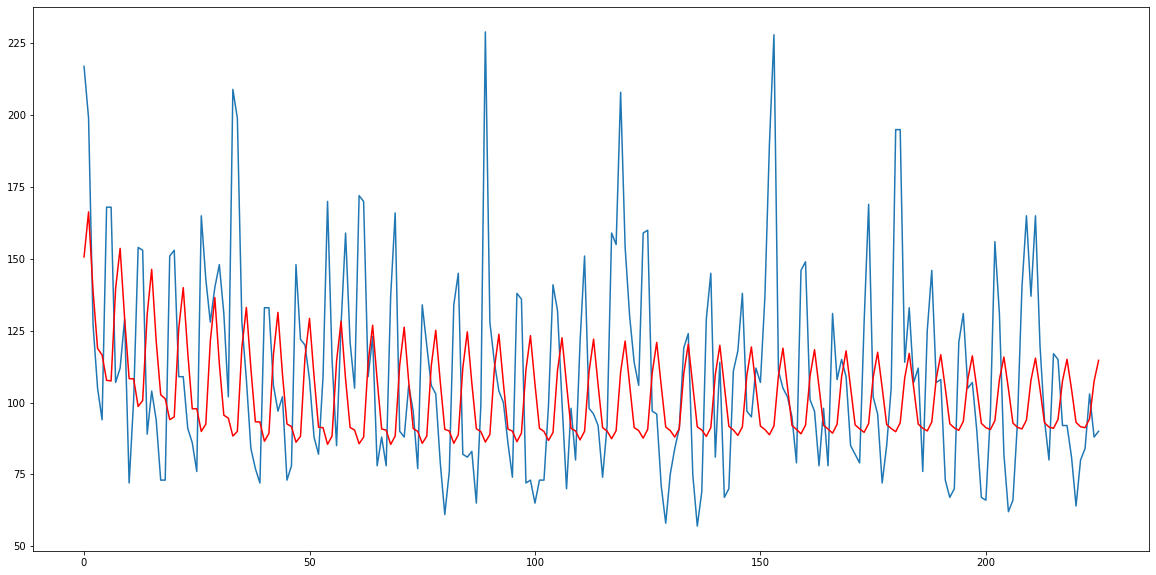

In [189]:
plt.plot(X_test)
plt.plot(predictions, color='red')
plt.show()
#предсказание получилось плохое

c:\Users\User\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8358
Model:                 ARIMA(6, 0, 6)   Log Likelihood              -33582.105
Date:                Fri, 29 Jul 2022   AIC                          67192.210
Time:                        16:38:00   BIC                          67290.644
Sample:                             0   HQIC                         67225.829
                               - 8358                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         99.6489     70.066      1.422      0.155     -37.677     236.975
ar.L1          1.3956      0.024     59.002      0.000       1.349       1.442
ar.L2         -1.5557      0.042    -37.102      0.0

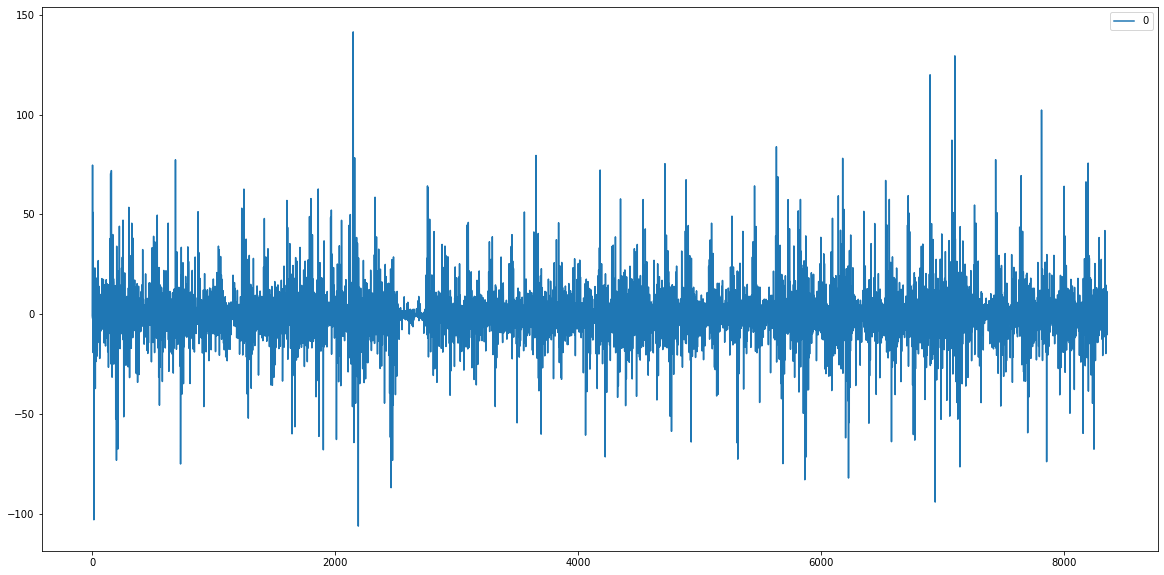

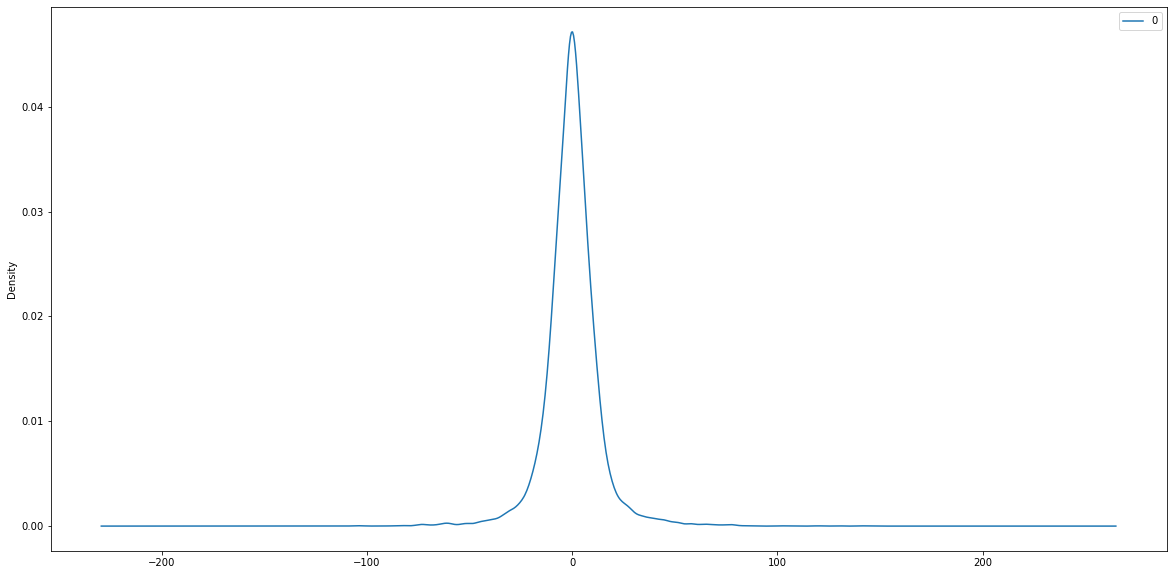

                 0
count  8358.000000
mean     -0.001333
std      13.484024
min    -105.913073
25%      -5.974803
50%      -0.078599
75%       5.715716
max     141.352448


In [191]:
# тестовая и тренировочная выборки определены ранее
X_train, X_test = gdf11.iloc[:sgaps].iloc[:,1:], gdf11.iloc[sgaps:].iloc[:,1:]
y_train, y_test = gdf11['unit_sales'].iloc[:sgaps],gdf11['unit_sales'].iloc[sgaps:]

#в качестве ARMA принимается arima с нулевым параметром d
ARMA_model = ARIMA(X_train.values.reshape(-1).tolist(), order=(6,0, 6)).fit()

# summary of fit model
print(ARMA_model.summary())
# line plot of residuals
residuals = pd.DataFrame(ARMA_model.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [193]:
predictions = ARMA_model.predict(start=len(X_train), end=len(X_train) + len(X_test)-1, dynamic=False)

print("mean_squared_error",mean_squared_error(y_test, predictions))
print("mean_absolute_error",mean_absolute_error(y_test, predictions))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, predictions))


mean_squared_error 2191.7790576516745
mean_absolute_error 38.04457848578587
mean_absolute_percentage_error 0.36572655469445164


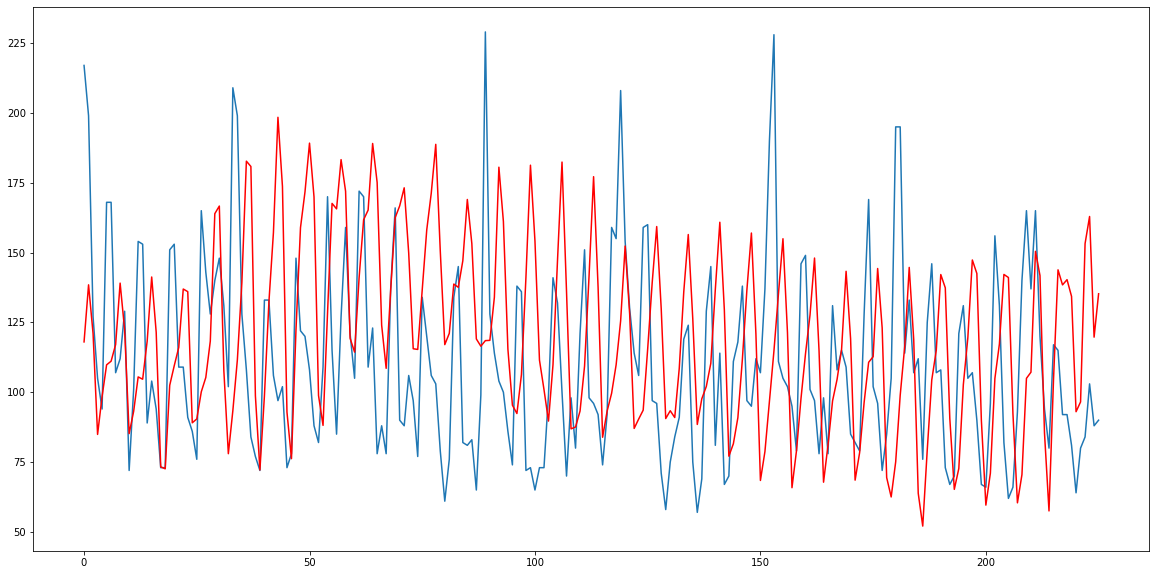

In [196]:
plt.plot(y_test.values)
plt.plot(predictions, color='red')
plt.show()
#при входе значений лагов, как в обучающем нотбуке, результат тоже  неудовлетворительный
#объяснения по ARIMA в курсе невнятные, учебные  материалы предлагаются устаревшие и с ошибками.


In [216]:
sdf11=gdf11['unit_sales']
sdf11.index


DatetimeIndex(['2013-01-08', '2013-01-09', '2013-01-10', '2013-01-11',
               '2013-01-12', '2013-01-13', '2013-01-14', '2013-01-15',
               '2013-01-16', '2013-01-17',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', name='date', length=1619, freq=None)

In [217]:
#ARIMA модель
from statsmodels.tsa.arima.model import ARIMA
X_train, X_test=sdf11.iloc[:sgaps],sdf11.iloc[sgaps:]
model = ARIMA(X_train.values, order=(6,1,6)).fit()

c:\Users\User\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [218]:

shown_train_size = 150
train_size = len(X_train.values)
test_size = len(X_test.values) 
# ax = X_test.set_axis(pd.Series(range(shown_train_size, shown_train_size + test_size))).plot(ax=ax)
prediction=model.predict(start=train_size-shown_train_size,end=train_size+test_size -1,dynamic=False)


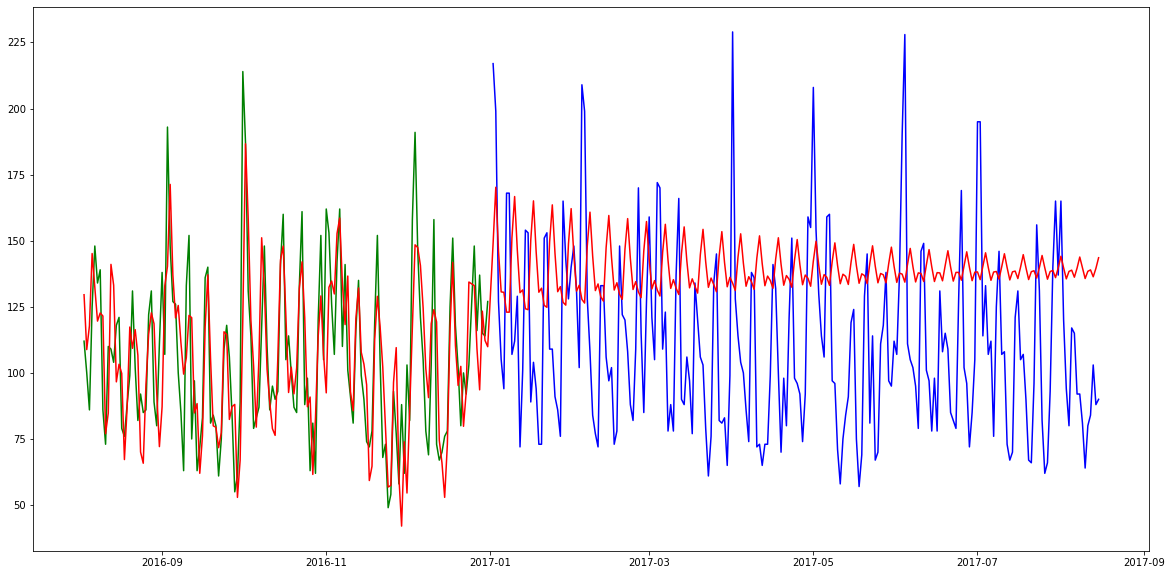

In [223]:
plt.plot(X_train.iloc[train_size-shown_train_size:],color='green') #кусочек train, который попал в fit
plt.plot(X_test,color='blue') #весь тест
Xprediction=pd.Series(prediction).set_axis(sdf11.index[train_size-shown_train_size:])
plt.plot(Xprediction,color='red') #predict фмтовой части и тестовой части
#нифига не получилось нормально предсказать

In [226]:
Xpredictions=Xprediction[shown_train_size:]
print(X_test.shape,Xpredictions.shape)
print("mean_squared_error",mean_squared_error(X_test, Xpredictions))
print("mean_absolute_error",mean_absolute_error(X_test, Xpredictions))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(X_test, Xpredictions))

(226,) (226,)
mean_squared_error 2124.6921480014284
mean_absolute_error 40.79375035541416
mean_absolute_percentage_error 0.4403084007159244


In [ ]:
#метрики для разных моделей:
#linearregression
# mean_squared_error 907.1733977063598
# mean_absolute_error 22.858131609015366
# mean_absolute_percentage_error 0.2060459359095241

#ARMA как ARIMA при d=0(без передачи на вход лагов)
# mean_squared_error 1531.620051093782
# mean_absolute_error 29.927933535704415
# mean_absolute_percentage_error 0.25859186608810764

#ARMA как ARIMA при d=0 (с передачей на вход лагов)
# mean_squared_error 2191.7790576516745
# mean_absolute_error 38.04457848578587
# mean_absolute_percentage_error 0.36572655469445164)

#ARIMA (d=1)
# mean_squared_error 2124.6921480014284
# mean_absolute_error 40.79375035541416
# mean_absolute_percentage_error 0.4403084007159244

# лучше всего в лоб сработала линейная регрессия, специализированные модели ARMA и ARIMA не настроены,
# учебные материалы, представленные на платформе не помогают разобраться в деталях


In [4]:
#FPProphet

df=pd.read_csv(f'{DIR}train.csv',sep=',',decimal='.',parse_dates=['date'])


c:\Users\User\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   item_nbr     int64         
 4   unit_sales   float64       
 5   onpromotion  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 5.6+ GB


In [11]:
gdfus=df[['date','unit_sales']].groupby(['date']).sum()
gdfus.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1684 entries, 2013-01-01 to 2017-08-15
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   unit_sales  1684 non-null   float64
dtypes: float64(1)
memory usage: 26.3 KB


In [14]:
gdfus.to_csv(f'{DIR}gdfus.csv')


In [17]:

gdfus_=pd.read_csv(f'{DIR}gdfus.csv',index_col='date',parse_dates=['date'])
gdfus_.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', name='date', length=1684, freq=None)